In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 4.2MB/s 
     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 7.9MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
key = "8eea39b79f694034b165ef58d1f037f7"
search_url = "https://api.bing.microsoft.com/v7.0/images/search"


In [5]:
def search_images_bing(key, search_term, min_sz=200, max_images=1000,  offset = 0):
  headers = {"Ocp-Apim-Subscription-Key" : key}
  params  = {"q": search_term, "license": "public", "imageType": "photo", "count":150, "offset":1}
  response = requests.get(search_url, headers=headers, params=params)
  response.raise_for_status()
  return L(response.json()['value'])
 

In [6]:
results = search_images_bing(key, "Masks in public")

In [7]:
images = results.attrgot('contentUrl')


In [8]:
dest = '/content/gdrive/MyDrive/Images/Masks/'


In [ ]:
download_images(dest, urls = images)

In [49]:
mask_types = 'good use of masks in public for coronavirus','wrong use of masks in public for coronavirus'
path = Path('/content/gdrive/MyDrive/Masks')

In [50]:
for o in mask_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, o)

  download_images(dest, urls=results.attrgot('contentUrl'))
  

In [51]:
fns = get_image_files(path)
fns

(#260) [Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000002.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000005.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000003.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000006.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000004.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000000.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000001.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000007.jpg'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000009.png'),Path('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000011.jpg')...]

In [52]:
failed = verify_images(fns)
failed

(#0) []

In [53]:
failed.map(Path.unlink);

In [54]:
masks = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [55]:
dls = masks.dataloaders(path)

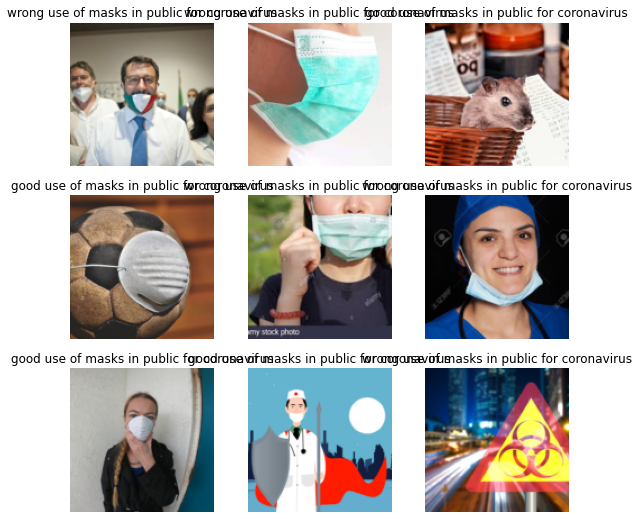

In [57]:
dls.valid.show_batch(max_n=9, nrows=3)

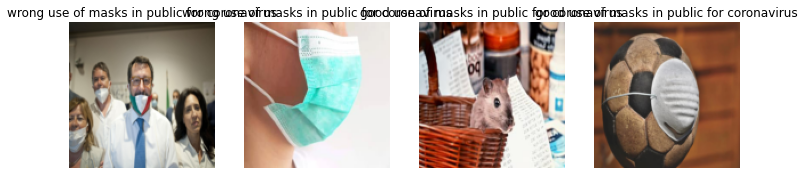

In [58]:
masks = masks.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = masks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

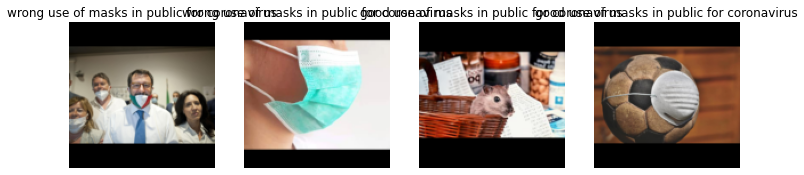

In [59]:
masks = masks.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = masks.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

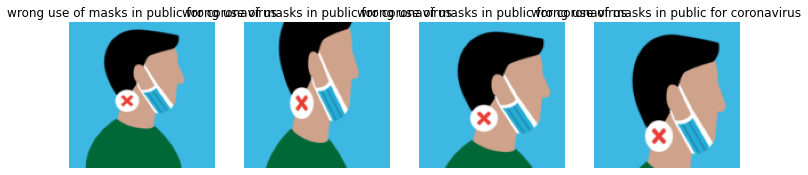

In [60]:
masks = masks.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = masks.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

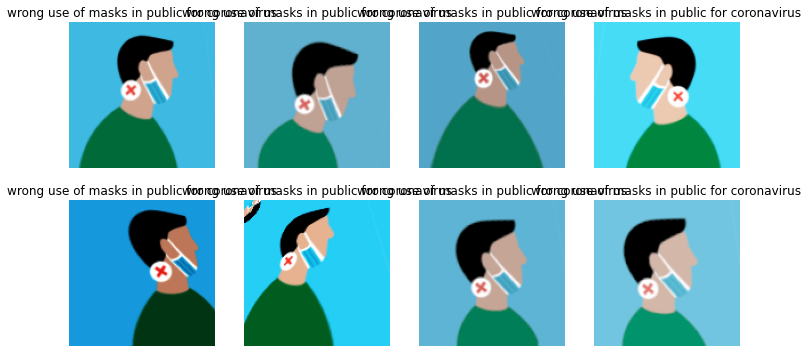

In [61]:
masks = masks.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = masks.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [62]:
masks = masks.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = masks.dataloaders(path)

In [63]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.306508,0.963368,0.384615,00:58


epoch,train_loss,valid_loss,error_rate,time
0,0.881242,0.887447,0.365385,01:05
1,1.037311,0.996104,0.403846,01:04
2,1.098958,1.038670,0.423077,01:04
3,1.030404,1.168027,0.519231,01:04
4,0.984887,1.343174,0.519231,01:03
5,0.948747,1.466781,0.519231,01:04
6,0.920573,1.527063,0.519231,01:03
7,0.896960,1.539611,0.519231,01:04


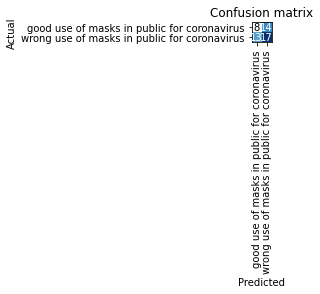

In [64]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

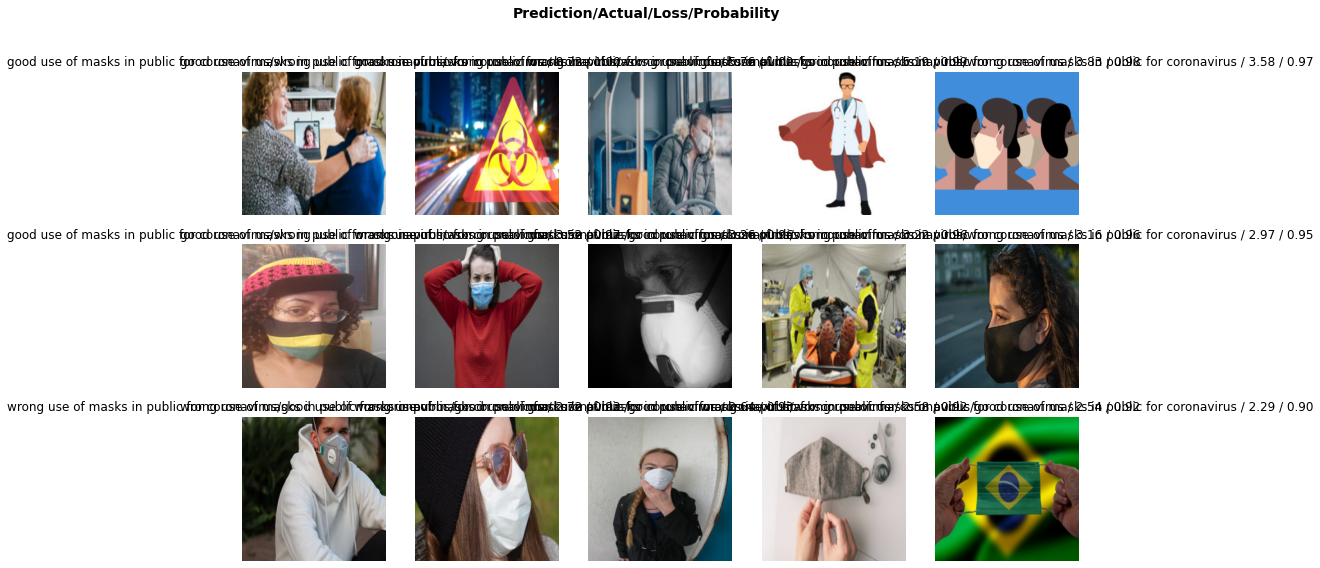

In [65]:
interp.plot_top_losses(15, nrows=3)

In [66]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [67]:
path

Path('/content/gdrive/MyDrive/Masks')

In [69]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: ignored

In [70]:
learn.export()

In [71]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [72]:
learn_inf = load_learner(path/'export.pkl')

In [74]:
learn_inf.predict('/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000001.jpg')

('good use of masks in public for coronavirus',
 tensor(0),
 tensor([0.9736, 0.0264]))

In [75]:
learn_inf.dls.vocab

['good use of masks in public for coronavirus', 'wrong use of masks in public for coronavirus']

In [77]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['/content/gdrive/MyDrive/Masks/good use of masks in public for coronavirus/00000001.jpg'])

In [78]:
img = PILImage.create(btn_upload.data[-1])

In [79]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [80]:
pred,pred_idx,probs = learn_inf.predict(img)

In [81]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: good use of masks in public for coronavirus; Probability: 0.9736')

In [82]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [83]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [84]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [86]:
#hide_output
VBox([widgets.Label('Select your mask picture!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [87]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.9MB 4.8MB/s 
     |████████████████████████████████| 194kB 11.0MB/s 
     |████████████████████████████████| 112kB 19.7MB/s 
     |████████████████████████████████| 552kB 18.7MB/s 
     |████████████████████████████████| 430kB 31.2MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7667 sha256=0fb2639ee03d44d9ab27613967795b7c6a71d7ce9c61eab060bb1ea38e5bb196
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
ERROR: nbdev 1.1.12 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; python_version >= "3.0", but you'll have tornado 6.1 which is incompatible.
  Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
 

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
